In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score, v_measure_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree, naive_bayes, svm

from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

#Подготовка и нормализация данных

In [ ]:
df = pd.read_csv('data/students_preprocessed.csv', sep = ',')
students_df = df[list(('school', 'sex', 'age', 'Pstatus', 'studytime', \
                                  'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'higher', \
                                  'internet', 'absences', 'G1', 'G2', 'G3'))]

In [ ]:
students_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   school      395 non-null    int64
 1   sex         395 non-null    int64
 2   age         395 non-null    int64
 3   Pstatus     395 non-null    int64
 4   studytime   395 non-null    int64
 5   failures    395 non-null    int64
 6   schoolsup   395 non-null    int64
 7   famsup      395 non-null    int64
 8   paid        395 non-null    int64
 9   activities  395 non-null    int64
 10  higher      395 non-null    int64
 11  internet    395 non-null    int64
 12  absences    395 non-null    int64
 13  G1          395 non-null    int64
 14  G2          395 non-null    int64
 15  G3          395 non-null    int64
dtypes: int64(16)
memory usage: 49.5 KB


In [ ]:
X = students_df.drop('G3', axis = 1)
y = students_df.G3

In [ ]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size = 0.2)

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
minmax_scaler = MinMaxScaler()
minmax_scaler.fit(X_train)
X_train_positive = minmax_scaler.transform(X_train)
X_test_positive = minmax_scaler.transform(X_test)

#Отбор признаков

## 1. Одномерный отбор признаков

In [ ]:
fit = SelectKBest(score_func=chi2, k=4).fit(X_train_positive, y_train)

np.set_printoptions(precision=3)
features = fit.transform(X_train_positive)
X_train_K_best = fit.transform(X_train_positive)
X_test_K_best = fit.transform(X_test_positive)

print(fit.scores_)

[12.948  8.871  3.279 16.75   4.338 36.038 29.64   5.606 14.374  9.595
  1.23   3.104  8.144 25.423 18.118]


## 2. Рекурсивное исключение признаков

In [ ]:
fit = RFE(LogisticRegression(), 3).fit(X_train, y_train)

X_train_recursive = fit.transform(X_train_positive)
X_test_recursive = fit.transform(X_test_positive)

print('Num features: {}'.format(fit.n_features_))
print('Selected Features: {}'.format(fit.support_))
print('Feature Ranking: {}'.format(fit.ranking_))

Num features: 3
Selected Features: [False False False False False False False False False False False False
  True  True  True]
Feature Ranking: [10 12  8  6  3  2  5  9  7  4 13 11  1  1  1]


## 3. Метод главных компонент

In [ ]:
fit = PCA(n_components=3).fit(X_train)
features = fit.transform(X_train)

X_train_pca = fit.transform(X_train_positive)
X_test_pca = fit.transform(X_test_positive)

print(fit.explained_variance_ratio_)
print(features[0:5,:])

[0.164 0.127 0.1  ]
[[-0.507 -0.651 -1.104]
 [ 0.055 -0.366 -0.043]
 [ 0.186  0.519  0.548]
 [ 2.125  0.938  1.091]
 [-1.167 -2.504 -0.963]]


## 4. Отбор на основе важности признаков

In [ ]:
fit = ExtraTreesClassifier().fit(X_train, y_train)
important = fit.feature_importances_ > 0.1
X_train_etc = X_train_positive[:, important]
X_test_etc = X_test_positive[:, important]

# Обучение модели

In [ ]:
def print_metrics(X, y, y_pred):
  print(silhouette_score(X, y_pred))
  print(v_measure_score(y, y_pred))

In [ ]:
def get_plot_3d(x, y, z, target):
  ax = Axes3D(plt.figure(figsize=(12, 12)))
  ax.scatter(x, y, z, c=target, marker='o')
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')
  plt.show()

In [ ]:
def fit_predict(X_train, X_test, y_train, y_test, model, init_parameters={}, **parameters):
  clustering_model = model(**init_parameters)
  clustering_model.fit(X_train)
  y_pred = clustering_model.predict(X_test)
  
  print_metrics(X_test, y_test, y_pred)
  
  if X_test.shape[1] == 2:
    get_plot_2d(X_test[:, 0], X_test[:, 1], y_pred)
  elif X_test.shape[1] == 3:
    get_plot_3d(X_test[:, 0], X_test[:, 1], X_test[:, 2], y_pred)
  else:
    while X_test.shape[1] < 3:
      X_test = np.hstack((X_test, np.zeros((X_test.shape[0], 1))))
    pca_3d = PCA(n_components=3).fit_transform(X_test, y_test)
    get_plot_3d(pca_3d[:, 0], pca_3d[:, 1], pca_3d[:, 2], y_pred)

In [ ]:
def selections_features(model, custom_fit_predict=None, init_parameters={}, **parameters):
  if custom_fit_predict:
    fit_predict = custom_fit_predict
  
  print('Без отбора признаков\n')
  fit_predict(X_train, X_test, y_train, y_test, model=model, init_parameters=init_parameters, **parameters)

  print('\n\n\nОдномерный отбор признаков\n')
  fit_predict(X_train_K_best, X_test_K_best, y_train, y_test, model=model, init_parameters=init_parameters, **parameters)

  print('\n\n\nРекурсивное исключение признаков\n')
  fit_predict(X_train_recursive, X_test_recursive, y_train, y_test, model=model, init_parameters=init_parameters, **parameters)

  print('\n\n\nМетод главных компонент\n')
  fit_predict(X_train_pca, X_test_pca, y_train, y_test, model=model, init_parameters=init_parameters, **parameters)

  print('\n\n\nОтбор на основе важности признаков\n')
  fit_predict(X_train_etc, X_test_etc, y_train, y_test, model=model, init_parameters=init_parameters, **parameters)

# KMeans

Без отбора признаков

0.1336410943090462
0.18457555381986018


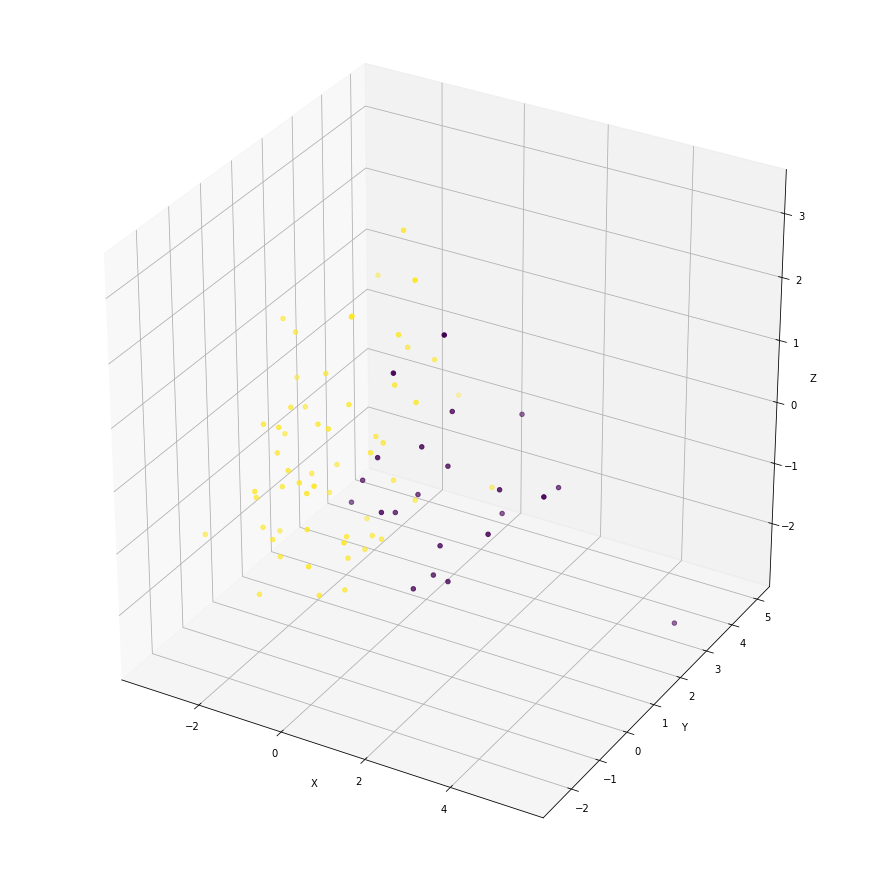




Одномерный отбор признаков

0.5911380173974411
0.11297766209036557


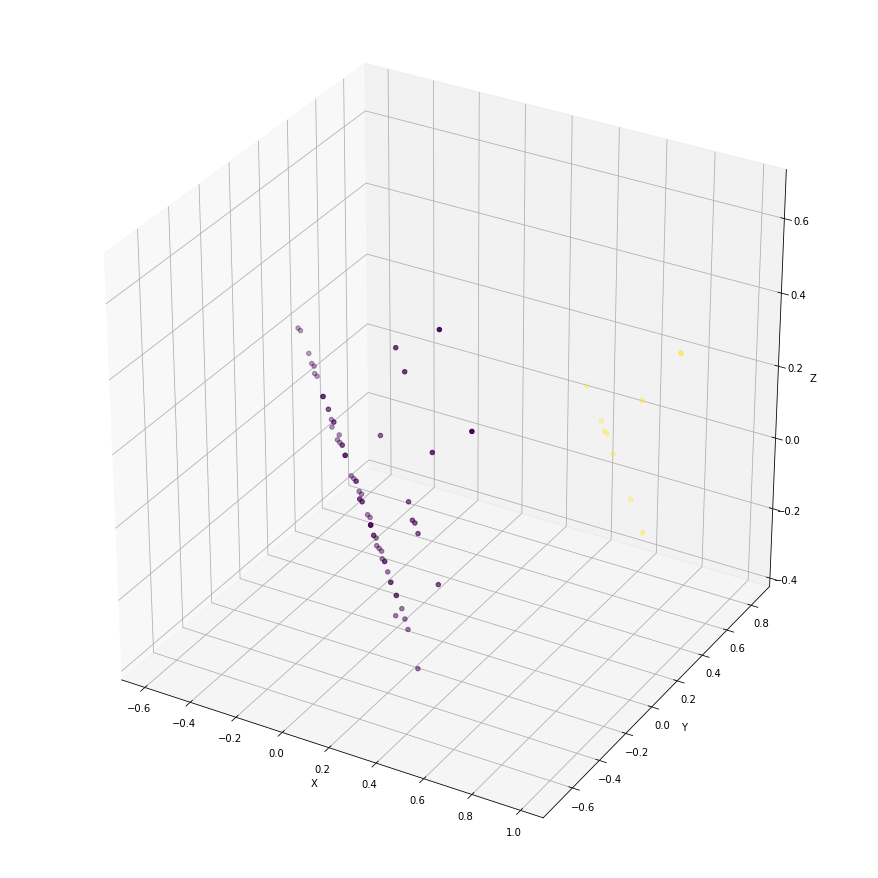




Рекурсивное исключение признаков

0.4635819470582263
0.3171716066659291


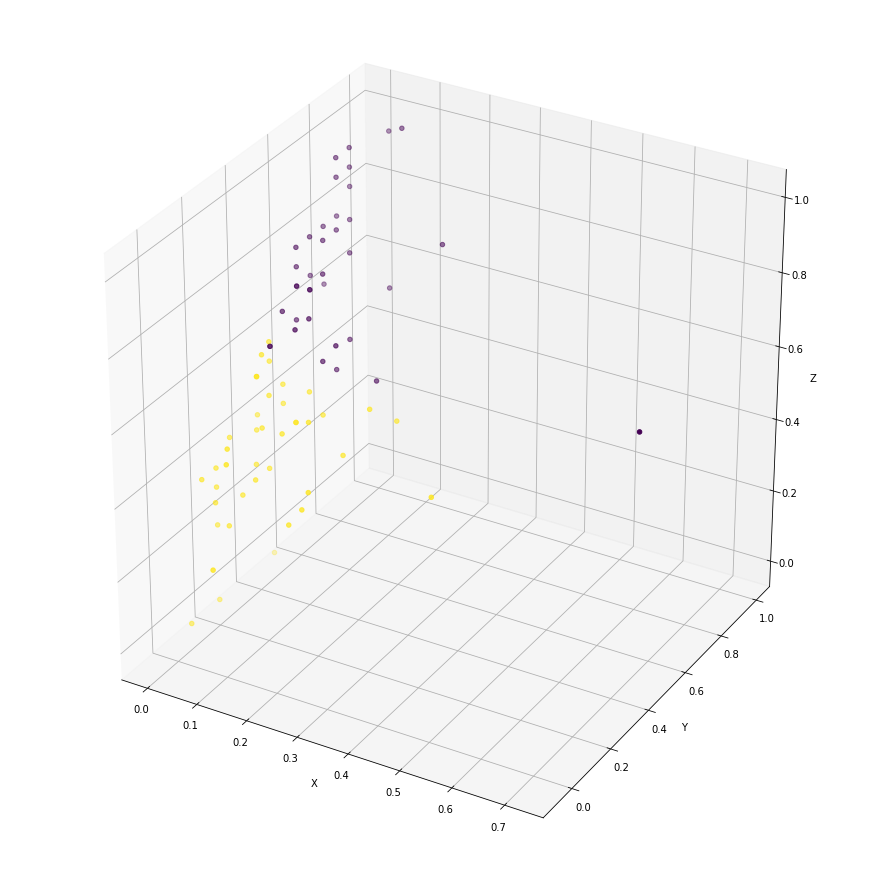




Метод главных компонент

0.34121260599434994
0.06600542619425907


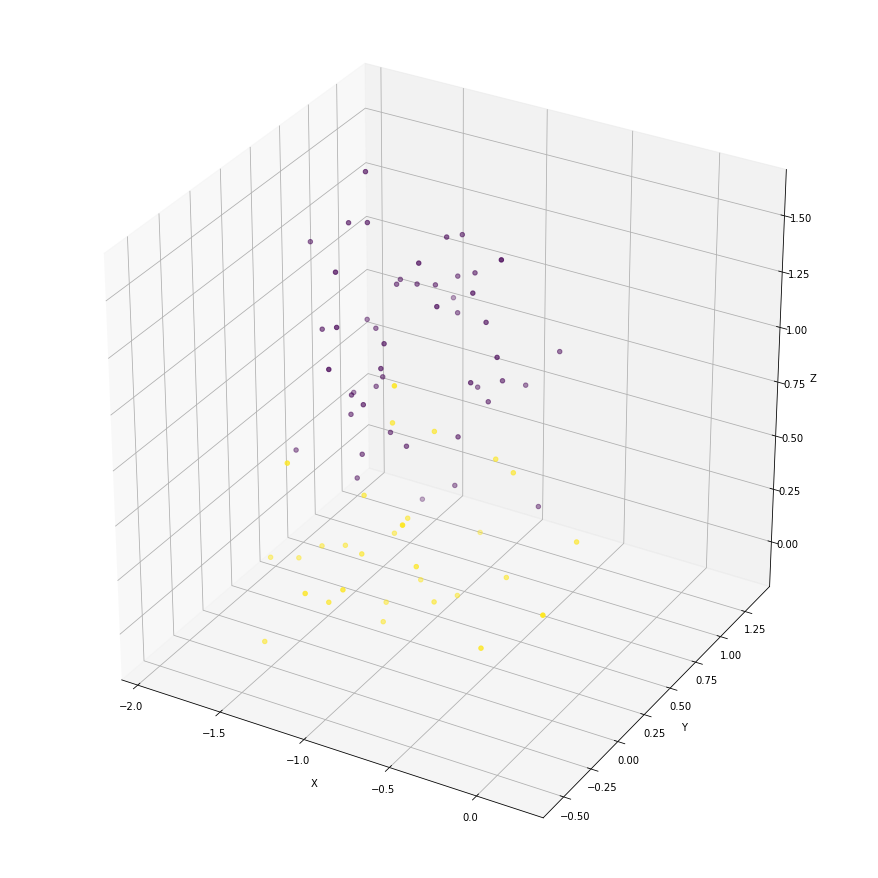




Отбор на основе важности признаков

0.4635819470582263
0.3171716066659291


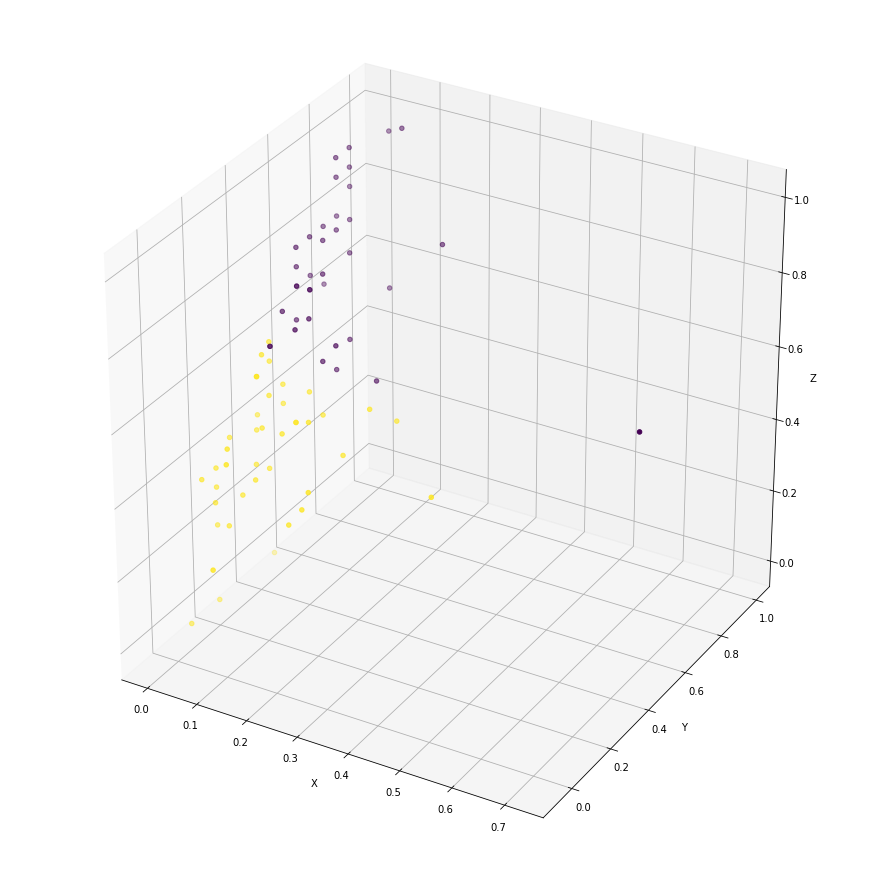

In [ ]:
selections_features(model=KMeans, init_parameters={'n_clusters': 2, 'max_iter': 200})

# t-SNE

Без отбора признаков




Одномерный отбор признаков




Рекурсивное исключение признаков




Метод главных компонент




Отбор на основе важности признаков



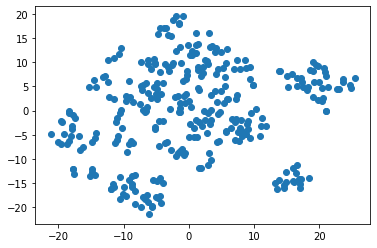

In [60]:
def custom_fit_predict_TSNE(X_train, X_test, y_train, y_test, model, init_parameters, **parameters):
  return model(**init_parameters).fit_transform(X_train, y_train), y_train, y_train

selections_features(model=TSNE, custom_fit_predict=custom_fit_predict_TSNE, init_parameters={'learning_rate': 100, 'n_components': 3})

# Обучаем модель
transformed = TSNE(learning_rate=100).fit_transform(X_train, y_train)

# Представляем результат в двумерных координатах
x_axis = transformed[:, 0]
y_axis = transformed[:, 1]

plt.scatter(x_axis, y_axis)
plt.show()